In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy 

In [2]:
def gaussweights(a, b, N):
    x, weights = np.polynomial.legendre.leggauss(N)
    x = (b - a) / 2 + x * (b - a) / 2
    weights = weights * (b - a) / 2
    return x, weights

In [3]:
N = 10
a, b = 0, np.pi

x, weights = gaussweights(a, b, N)
np.sum(weights * np.sin(x))

2.0000000000000004

In [4]:
from scipy.special import spherical_jn as jn

l = 0

def Vk(kp, k):
    return lam * (b ** 2) * jn(l, b * k) * jn(l, b * kp) / (2 * mu)

def schrodingerLHS(i, j):
    return k[i] ** 2 / (2 * mu) * (i == j) + 2 / np.pi * w[i] * k[i] **2 * Vk(k[i], k[j])

In [5]:
N = 32
b = 5
mu = 0.5
l = 0
lam = -10
k, w = gaussweights(0, 200, N)

A = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        A[i, j] = schrodingerLHS(i, j)

In [6]:
E, v = np.linalg.eig(A)

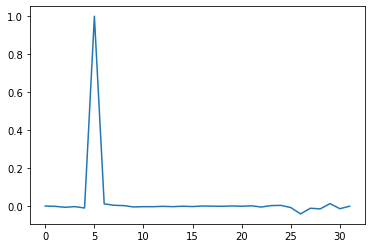

In [7]:
plt.plot(v[np.where(E<0)][0])

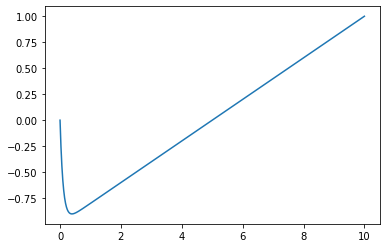

In [8]:
def expr(kap):
    return np.exp(-2 * kap * b) - 1 - 2 * kap / lam

kap = np.linspace(0, 10, 1000)
plt.plot(kap, expr(kap))

In [9]:
from scipy.optimize import bisect

kap = bisect(expr, 0.1, 10)
Ekap = -kap ** 2 / (2 * mu)
Ekap

-25.00000000000421

In [10]:
def wavepacket(x, x0, sigma0, kx, y=0, y0=0, ky=0):
    return np.exp(-0.5 * ((x - x0) ** 2 + (y - y0) ** 2) / sigma0 ** 2) * np.exp(1j * (kx * x + ky * y))

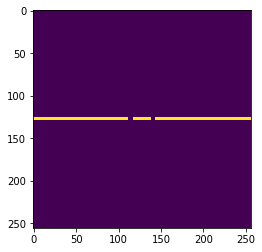

In [15]:
N = 256

X = 10
Y = 10
T = 0.5

dx = X / N
dt = (dx / 4) ** 2

x = np.arange(0, X, dx)
y = np.arange(0, Y, dx)

xv, yv = np.meshgrid(x, y)

x0 = 3
y0 = 5

kx = 6 * np.pi
ky = 0
sigma0 = 0.5

psi = wavepacket(xv, x0, sigma0, kx, yv, y0, ky)

psi0 = psi.copy()
psi1 = psi.copy()
psi2 = psi.copy()
psi0[0, :] = 0
psi0[-1, :] = 0 
psi0[:, 0] = 0
psi0[:, -1] = 0

V = np.zeros_like(xv)

wallpos = 5
wallthickness = .15
iwall = list(range(int((wallpos-wallthickness/2)/dx),int((wallpos+wallthickness/2)/dx),1))
V[:,iwall] = 3000

slitdist = 1
slitwidth = .2

islit1 = (int((X/2-slitdist/2-slitwidth/2)/dx),int((X/2-slitdist/2+slitwidth/2)/dx))
islit2 = (int((X/2+slitdist/2-slitwidth/2)/dx),int((X/2+slitdist/2+slitwidth/2)/dx))

V[islit1[0]:islit1[1],iwall] = 0
V[islit2[0]:islit2[1],iwall] = 0

plt.imshow(V.transpose())
plt.show()

i = slice(1, -1, 1)
i_l = slice(None, -2, 1)
i_r = slice(2, None, 1)

j = slice(1, -1, 1)
j_l = slice(None, -2, 1)
j_r = slice(2, None, 1)

rho = []

for n in range(int(T / dt)):
    
    if n % int(T / (100 * dt)) == 0:
        print(f"{len(rho)}", end="\r")
        rho.append(np.abs(psi0) ** 2)
    
    psi2[i, j] = psi0[i, j] - 2j * dt * (V[i, j] * psi1[i, j] - (psi1[i_r, j] + psi1[i_l, j] - 4 * psi1[i, j] + psi1[i, j_r] + psi1[i, j_l]) / (dx ** 2))
    psi0 = psi1.copy()
    psi1 = psi2.copy()


rho.append(np.abs(psi0) ** 2)
rho = np.asarray(rho)

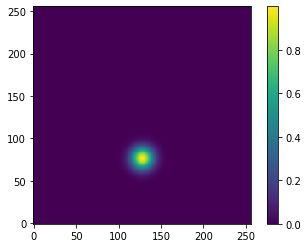

In [17]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
from matplotlib.colors import LogNorm, Normalize

fig = plt.figure()
plt.plot()
img = plt.imshow(rho[0].transpose(), origin='lower')
plt.colorbar()

def update(i):
    print(i, end='\r')
    img.set_array(rho[i].transpose())
    img.set_norm(Normalize(vmin = np.min(rho[i]), vmax = np.max(rho[i])))
    
ani = animation.FuncAnimation(fig, update, frames=rho.shape[0], interval=1000 / 30)
ani

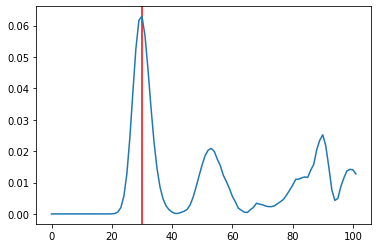

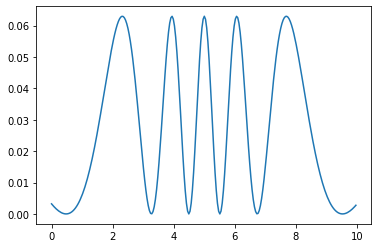

In [32]:
screendist = 3
iscreen = int((X / 2 + screendist) / dx)

scenter = rho[:,int(N/2), iscreen]
tmax = np.argmax(scenter)
plt.axvline(tmax, color='red')
plt.plot(scenter)
plt.show()

# theta = np.arctan((x - X / 2) / screendist)

I0 = scenter[tmax]
I = I0 * (np.cos(kx * slitdist * np.sin(theta) / 2) ** 2)

# plt.plot(rho[tmax, :, iscreen])
plt.plot(x, I)
# plt.plot(theta)